# Side-by-side panels: real vs synth windows

Displays N example windows (rows) and selected features (columns). For each feature we show a Real | Synth pair per row. Saves PNG and PDF under `outputs/figures/panels/`.


In [1]:
import os
os.chdir(r"C:\BDA_CEP_Part-2")
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Config (tweak these)
DATA_DIR = "data/processed/electricity"
SYN_PATH = "outputs/synth/synth_electricity_2000w.npy"
OUT_DIR = "outputs/figures/panels"
os.makedirs(OUT_DIR, exist_ok=True)

# Display options
n_examples = 4                   # rows (windows)
feature_indices = [0, 1, 2]      # features to show (columns)
random_sample_windows = False    # if True, randomly choose windows
RANDOM_SEED = 42
linewidth = 0.9


In [4]:
feat_names_path = os.path.join(DATA_DIR, "features.txt")
if os.path.exists(feat_names_path):
    feat_names = open(feat_names_path).read().splitlines()
else:
    feat_names = [f"f{i}" for i in range(100)]  # fallback names

# Load arrays
real_scaled = np.load(os.path.join(DATA_DIR, "test.npy"))   # scaled (num_windows, T, D)
synth_inv = np.load(SYN_PATH)                               # inverse-scaled (original units)

# Load scalers and convert to original units for plotting
with open(os.path.join(DATA_DIR, "scalers.pkl"), "rb") as f:
    scalers = pickle.load(f)  # This is a list of scalers

nreal, T, D = real_scaled.shape

# Convert real data from scaled back to original units using the list of scalers
real_orig = np.zeros_like(real_scaled)
for feature_idx in range(D):
    feature_data = real_scaled[:, :, feature_idx].reshape(-1, 1)
    orig_feature = scalers[feature_idx].inverse_transform(feature_data)
    real_orig[:, :, feature_idx] = orig_feature.reshape(nreal, T)

# synth_inv is assumed to be original units already (as saved earlier)
synth_orig = synth_inv

# Safety: ensure matching dims
assert synth_orig.shape[1] == T, "Synth and real time length mismatch"
assert synth_orig.shape[2] == D, "Synth and real feature dim mismatch"

# Cap n_examples to available windows
n_examples = min(n_examples, real_orig.shape[0], synth_orig.shape[0])
print(f"Preparing to plot {n_examples} windows × {len(feature_indices)} features (T={T}, D={D})")

Preparing to plot 4 windows × 3 features (T=168, D=7)


In [5]:
if random_sample_windows:
    rng = np.random.default_rng(RANDOM_SEED)
    win_idxs = rng.choice(np.arange(real_orig.shape[0]), size=n_examples, replace=False)
else:
    win_idxs = np.arange(n_examples)  # first n windows

print("Window indices:", win_idxs.tolist())


Window indices: [0, 1, 2, 3]


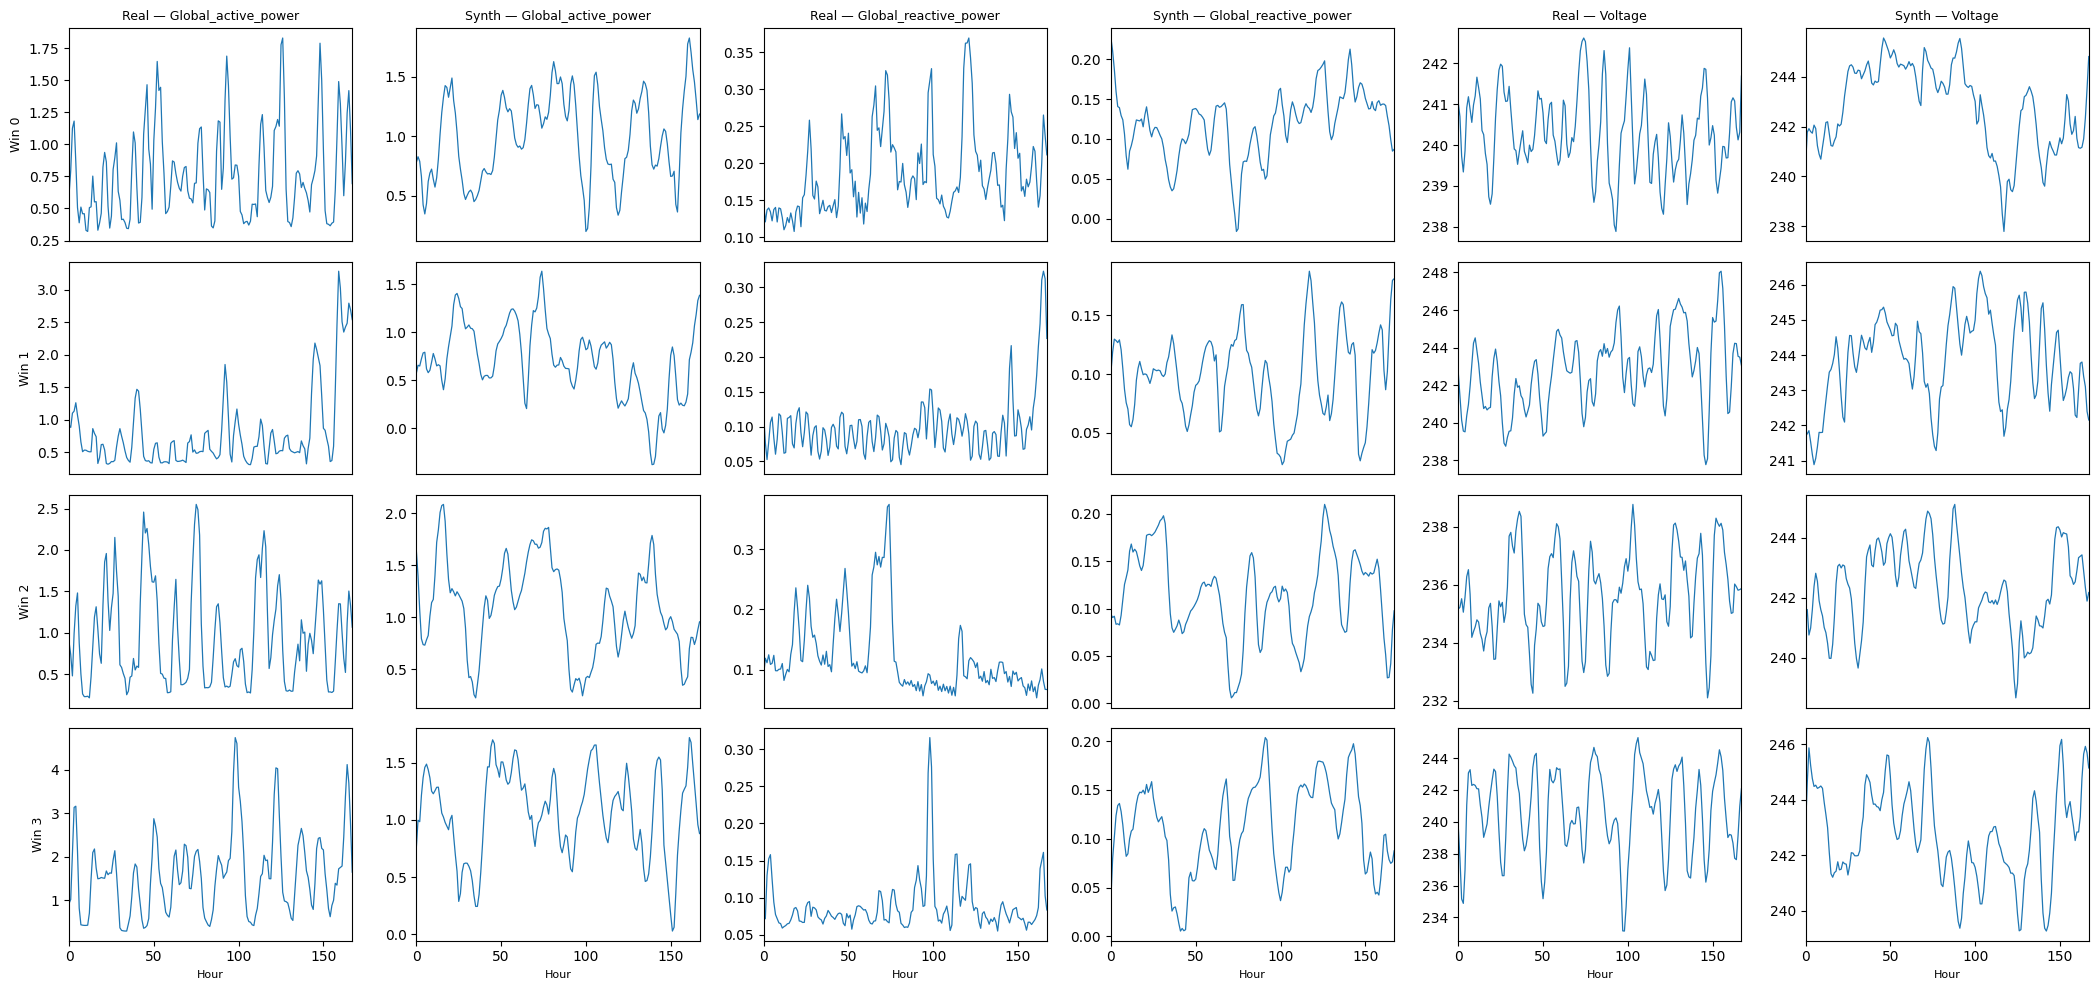

Saved panels to: outputs/figures/panels\side_by_side_panels_4w_3f.png outputs/figures/panels\side_by_side_panels_4w_3f.pdf


In [6]:
n_feats = len(feature_indices)
fig_w = 3.5 * (2 * n_feats)   # width scales with number of columns
fig_h = 2.5 * n_examples
fig, axes = plt.subplots(n_examples, 2 * n_feats, figsize=(fig_w, fig_h), squeeze=False)

time = np.arange(T)

for row_idx, win_idx in enumerate(win_idxs):
    for j, feat in enumerate(feature_indices):
        fname = feat_names[feat] if feat < len(feat_names) else f"f{feat}"
        # real
        ax_real = axes[row_idx, 2*j]
        ax_real.plot(time, real_orig[win_idx, :, feat], linewidth=linewidth)
        if row_idx == 0:
            ax_real.set_title(f"Real — {fname}", fontsize=9)
        ax_real.set_xlim(0, T-1)
        if j == 0:
            ax_real.set_ylabel(f"Win {win_idx}", fontsize=9)
        # synth
        ax_synth = axes[row_idx, 2*j+1]
        ax_synth.plot(time, synth_orig[win_idx, :, feat], linewidth=linewidth)
        if row_idx == 0:
            ax_synth.set_title(f"Synth — {fname}", fontsize=9)
        ax_synth.set_xlim(0, T-1)

        # disable x labels for non-bottom rows
        if row_idx < n_examples - 1:
            ax_real.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
            ax_synth.tick_params(axis="x", which="both", bottom=False, labelbottom=False)

# show x ticks on bottom row and label
for col in range(2 * n_feats):
    axes[-1, col].tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    axes[-1, col].set_xlabel("Hour", fontsize=8)

plt.tight_layout()
png_path = os.path.join(OUT_DIR, f"side_by_side_panels_{n_examples}w_{n_feats}f.png")
pdf_path = os.path.join(OUT_DIR, f"side_by_side_panels_{n_examples}w_{n_feats}f.pdf")
fig.savefig(png_path, dpi=200, bbox_inches="tight")
fig.savefig(pdf_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close(fig)
print("Saved panels to:", png_path, pdf_path)


In [7]:
# Save per-window per-feature summary: mean absolute error and Pearson corr between real & synth
import pandas as pd
from scipy.stats import pearsonr

rows = []
for row_idx, win_idx in enumerate(win_idxs):
    for feat in feature_indices:
        a = real_orig[win_idx, :, feat]
        b = synth_orig[win_idx, :, feat]
        mae = float(np.mean(np.abs(a - b)))
        try:
            corr = float(pearsonr(a, b)[0])
        except Exception:
            corr = float('nan')
        rows.append({
            "window": int(win_idx),
            "feature_idx": int(feat),
            "feature_name": feat_names[feat] if feat < len(feat_names) else f"f{feat}",
            "MAE": mae,
            "Pearson": corr
        })
summary_df = pd.DataFrame(rows)
csv_path = os.path.join(OUT_DIR, f"panel_summary_{n_examples}w_{n_feats}f.csv")
summary_df.to_csv(csv_path, index=False)
print("Saved small summary CSV to:", csv_path)
print(summary_df.head())


Saved small summary CSV to: outputs/figures/panels\panel_summary_4w_3f.csv
   window  feature_idx           feature_name       MAE   Pearson
0       0            0    Global_active_power  0.411642  0.167779
1       0            1  Global_reactive_power  0.074999  0.085744
2       0            2                Voltage  2.612046  0.135838
3       1            0    Global_active_power  0.550104 -0.142836
4       1            1  Global_reactive_power  0.041613  0.075044
